Create DataFrames for each patient to train SVM

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import SimpleITK as sitk
import glob
import os
import re
import matplotlib.pyplot as plt

Discrete DataFrame creation

116941


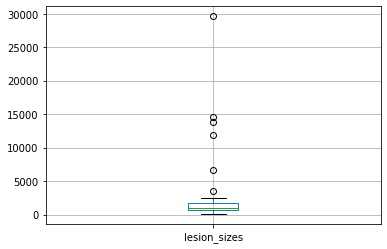

In [2]:
# function to create dataframe columns using lesion info
def create_col(dir, p_ID, mode):
    # modalities =  GM, MD, FA, FICVF, ODI
    modes = {'GM': dir + 'GM-LESIONS/',
            'MD': dir + 'MD-LESIONS/',
            'FA': dir + 'FA-LESIONS/',
            'FICVF': dir + 'FICVF-LESIONS/',
            'ODI': dir + 'ODI-LESIONS/'
           }
    # data is sitk image type
    # p_ID is patient ID (string)
    
    file = glob.glob( modes[mode] + "*" + p_ID + "*.nii")
    if not file:
        print(mode + " modality doesn't exist for " + p_ID)
        return [0] * 2122945 # voxels in flattened mri

    img = sitk.ReadImage(file[0])
    arr = sitk.GetArrayFromImage(img)
    arr = arr.flatten()
    return arr
   
gm_lesions_file_list = glob.glob("OUTPUT/DISCRETE/LESIONS/GM-LESIONS/*")
gm_lesions_file_list.sort()
    
patient_ids = []

for file in gm_lesions_file_list:
    patient_ids.append(re.search('.*(D[0-9][0-9][0-9]).*', os.path.basename(file)).group(1))


ALL_D_FRAMES =[]

# create discrete df
dir = "OUTPUT/DISCRETE/LESIONS/"

for patient in patient_ids:
    df = pd.DataFrame({'GM' : create_col(dir, patient, "GM"),
                        'FA' : create_col(dir, patient, "FA"),
                        'MD' : create_col(dir, patient, "MD"),
                        'FICVF' : create_col(dir, patient, "FICVF"),
                        'ODI' : create_col(dir, patient, "ODI") ,
                      
    })
    
    df = df[(df.T != 0).any()]
    df['target_name'] = "Discrete"
    df['target'] = 1
    df = df.reset_index(drop=True)    
    ALL_D_FRAMES.append(df)

sizes = []
for i in range(len(ALL_D_FRAMES)):
    sizes.append(ALL_D_FRAMES[i].shape[0])
tot = 0
for i in range(len(sizes)):
    tot = tot + sizes[i]
print(tot)

# check mean and range of sizes of lesions using boxplot 
df = pd.DataFrame(sizes, columns=['lesion_sizes'])
boxplot = df.boxplot()
plt.savefig("boxplot-image")

Control DataFrame creation

In [3]:
# get patient IDs
gm_lsn_files = glob.glob("OUTPUT/CONTROL/LESIONS/GM-LESIONS/*")
gm_lsn_files.sort()
patient_ids = []
for file in gm_lsn_files:
    patient_ids.append(re.search('.*(C[0-9][0-9][0-9]).*', os.path.basename(file)).group(1))

# create control df
dir = "OUTPUT/CONTROL/LESIONS/"
ALL_C_FRAMES = []
for patient in patient_ids:
    data = {'GM' : create_col(dir, patient, "GM"),
                        'FA' : create_col(dir, patient, "FA"),
                        'MD' : create_col(dir, patient, "MD"),
                        'FICVF' : create_col(dir, patient, "FICVF"),
                        'ODI' : create_col(dir, patient, "ODI"),      
    }
    df = pd.DataFrame(data, index=None)
    df = df[(df.T != 0).any()]
    df['target_name'] = "Control"
    df['target'] = 0
    df = df.reset_index(drop=True)    
    ALL_C_FRAMES.append(df)

In [4]:
print(len(ALL_D_FRAMES))
print(len(ALL_C_FRAMES))
hello  = ALL_C_FRAMES[0].shape[0]
all = pd.concat(ALL_C_FRAMES)

 
c_train = ALL_C_FRAMES[0:22] #get 44 controls for train, TEMPORARILY HALVED
d_train = ALL_D_FRAMES[0:16] # get 31 discrete for train, TEMPORARILY HALVED
c_train_df = pd.concat(c_train)
d_train_df = pd.concat(d_train)
train_df = c_train_df.append(d_train_df)
train_df = train_df.reset_index(drop=True)

c_test = ALL_C_FRAMES[22:32] # get 18 controls for test, TEMPORARILY HALVED
d_test = ALL_D_FRAMES[31:38] # get 13 discrete for test, TEMPORARILY HALVED

c_test_df = pd.concat(c_test)
d_test_df = pd.concat(d_test)
test_df = c_test_df.append(d_test_df)
test_df = test_df.reset_index(drop=True)

train_df.to_csv('train-data.csv')
test_df.to_csv('test-data.csv')


44
62


In [12]:
yeet = ALL_D_FRAMES[31]
print(yeet.shape)



(11836, 7)
